# Identifying Credit Card Fraud

In [7]:
import pandas as pd
import numpy as np

# for graphing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# training model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Load training data set

In [2]:
# Load the train.csv
train_file_path = 'data/train.csv'

# Load the train dataset
train_data = pd.read_csv(train_file_path)

train_data

,id,trans_num,trans_date,trans_time,unix_time,category,amt,cc_num,first,last,...,zip,lat,long,city_pop,job,dob,merchant,merch_lat,merch_long,is_fraud
0,308467,26ad750c2ff71f32631b58913582d70a,2024-01-10,06:49:39,1704887379,misc_pos,188.38,676355457570,Andrea,Johnson,...,62220,38.5127,-89.9847,95666,Accounting technician,1983-05-26,fraud_Turcotte-Halvorson,39.268874,-89.273447,0
1,261578,fea9c1efe3f2b97f27ad0ab5409ec861,2024-01-06,02:37:50,1704526670,grocery_pos,102.63,377178373574671,Rhonda,Chavez,...,21784,39.4567,-76.9696,37941,"Designer, graphic",1976-12-03,fraud_Schamberger-O'Keefe,39.961495,-76.707640,0
2,341,2ae350b982be840f3666273e0c2f3a05,2024-01-18,21:40:21,1705632021,entertainment,1.62,3599292013370451,Stephen,Khan,...,49735,45.0125,-84.6723,19515,Careers information officer,1999-08-24,"fraud_Nicolas, Hills and McGlynn",44.393561,-85.342323,0
3,1147639,bbdd8adfc0a34ed0e817f809193c85c0,2024-01-21,16:20:15,1705872015,health_fitness,5.64,3594292572430345,Justin,Reilly,...,44256,41.1404,-81.8584,62039,"Merchandiser, retail",1930-02-24,fraud_Cormier LLC,40.283764,-81.639361,0
4,314152,fc7756004dc2a9bc450eb894a670b804,2024-01-21,19:36:26,1705883786,health_fitness,97.09,4867547663675548,Alice,Duarte,...,91501,34.1862,-118.3009,106841,Prison officer,1951-10-15,fraud_Kulas Group,35.149704,-118.087440,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370698,537275,e12ddb8941f130255352b5caeff96a4a,2024-01-30,20:12:57,1706663577,personal_care,66.52,4683409080836793,Crystal,Campbell,...,92064,32.9756,-117.0402,47904,Accommodation manager,1985-08-21,fraud_Shanahan-Lehner,32.590264,-116.637104,0
370699,547158,8241d65a2a63ada8daa3e81552404726,2024-01-12,11:26:52,1705076812,grocery_pos,268.50,4003425099181,John,Ford,...,8816,40.4284,-74.4064,46298,"Geologist, engineering",1980-05-30,fraud_Cartwright-Harris,40.478154,-73.809412,1
370700,846873,4fa475d7984b78e8270015cec78292a6,2024-01-20,20:36:35,1705800995,food_dining,11.48,4262772365401,Ashley,Bell,...,55454,44.9682,-93.2429,1022298,"Engineer, drilling",1982-09-20,fraud_Runte-Mohr,45.321416,-93.573895,0
370701,283754,72d87943d4dc4de9f32d338a20b6544e,2024-01-06,06:12:49,1704539569,grocery_pos,2.86,376631334822978,Wanda,French,...,17315,40.0062,-76.8555,25756,Investment analyst,1961-03-11,"fraud_Lockman, West and Runte",39.703337,-77.572884,0


## Investigating Data

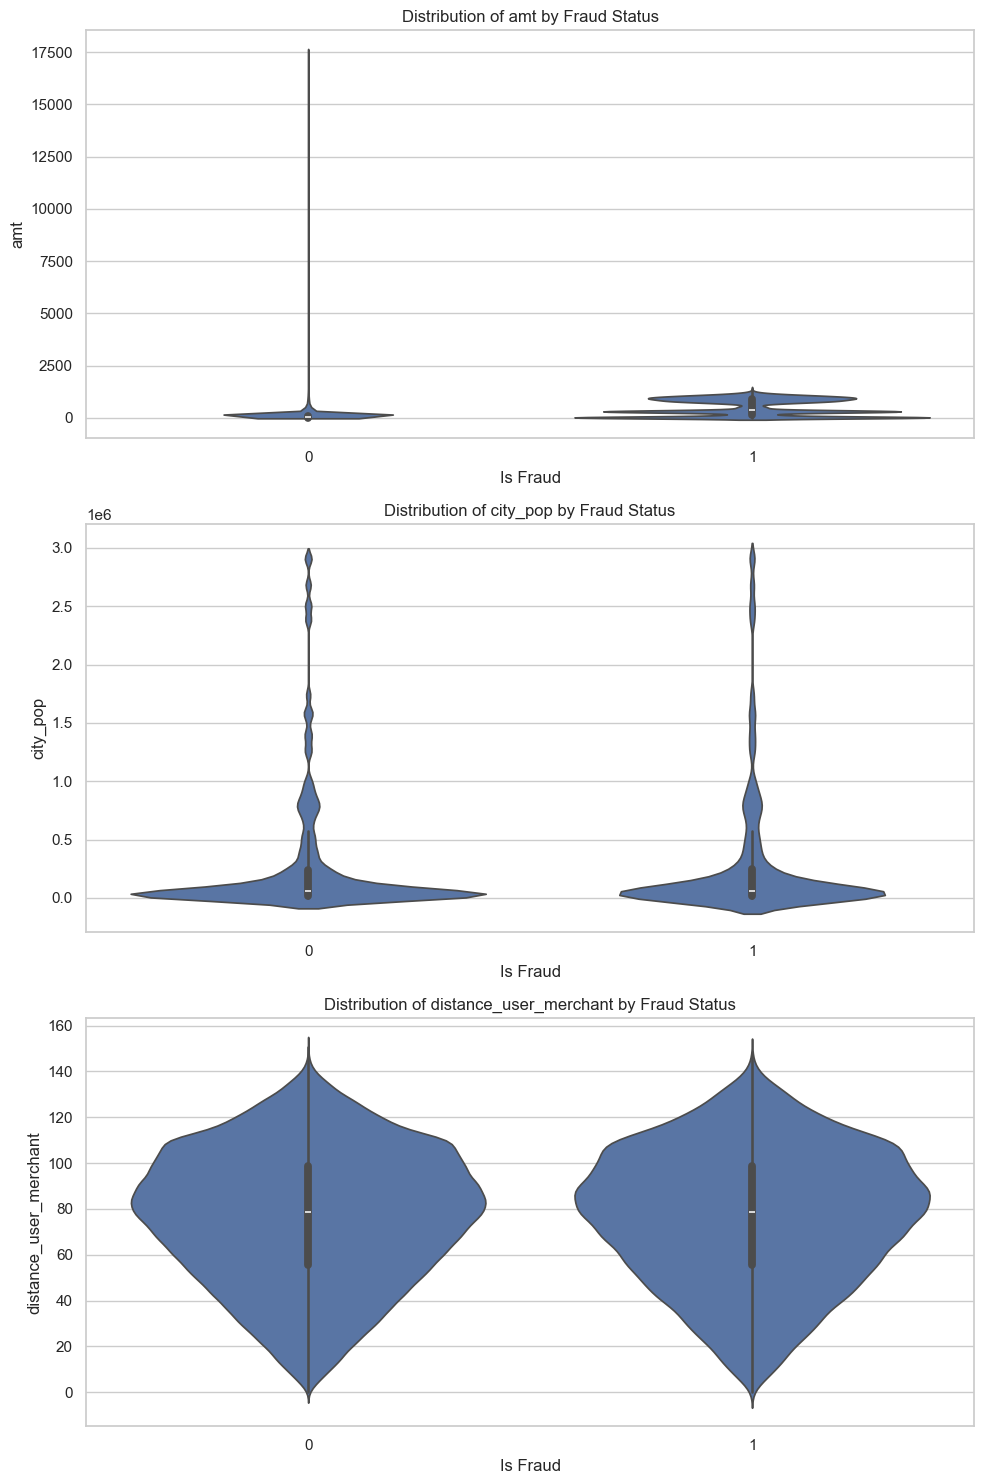

/var/folders/m1/hwqkt9_s4z9g4sf3b3xs1y100000gn/T/ipykernel_23201/58913903.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette="viridis")


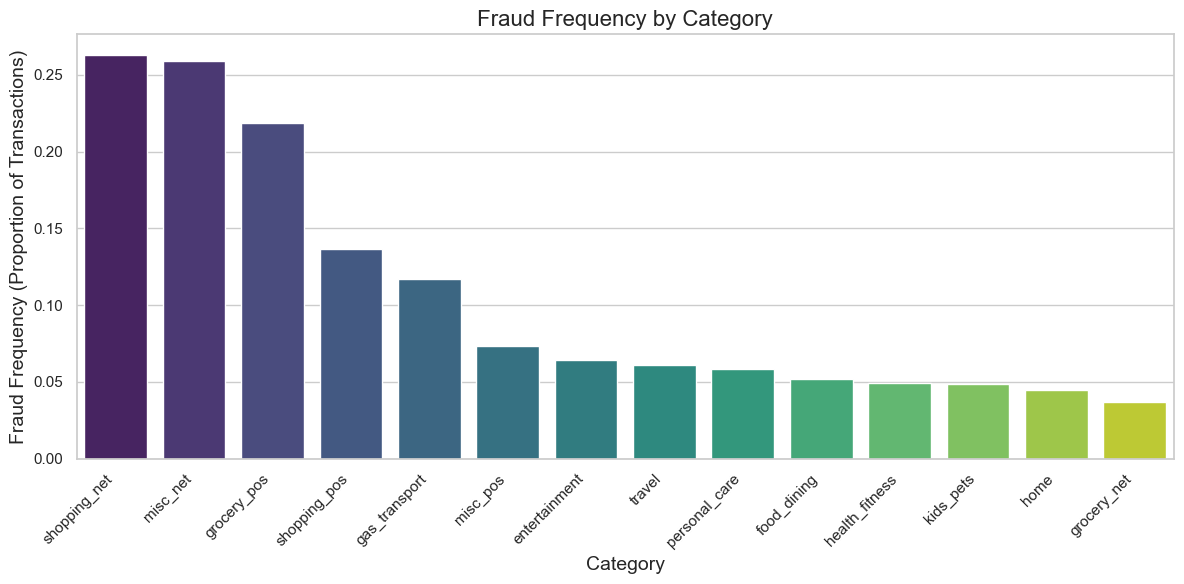

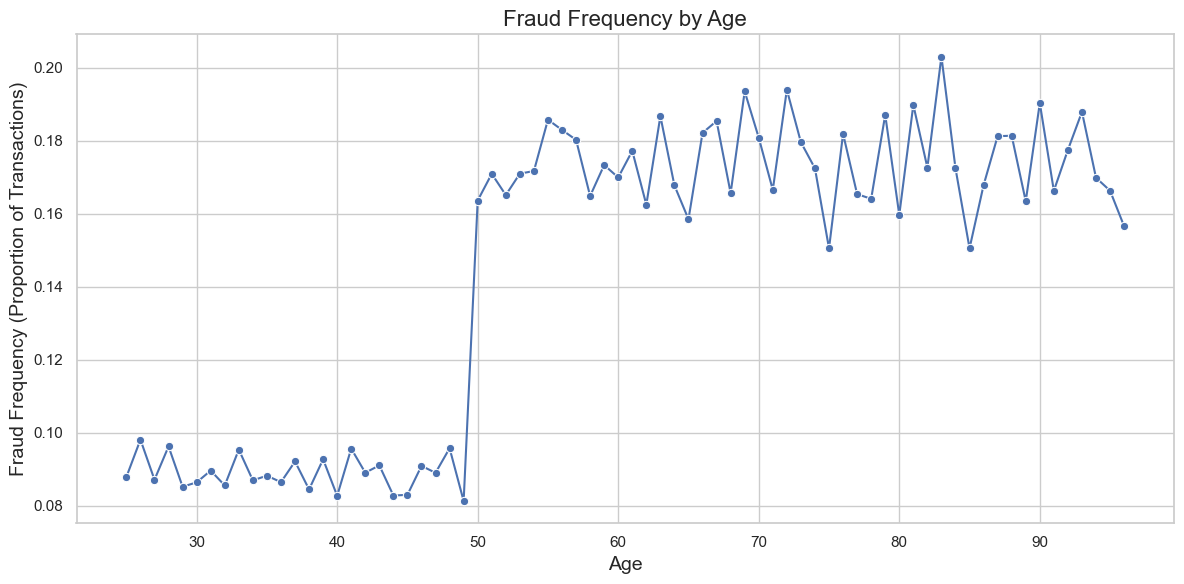

In [23]:
def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance in kilometers between two points on the earth."""
    R = 6371  # Radius of Earth in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Compute distance_user_merchant for train_data
if 'lat' in train_data.columns and 'merch_lat' in train_data.columns:
    train_data['distance_user_merchant'] = haversine(
        train_data['lat'], train_data['long'], train_data['merch_lat'], train_data['merch_long']
    )

# Verify the columns for numerical exploration
numerical_columns = ['amt', 'city_pop', 'distance_user_merchant', 'age']
available_columns = [col for col in numerical_columns if col in train_data.columns]

# Reinitialize the grid of plots
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=len(available_columns), figsize=(10, 5 * len(available_columns)))

# Create a violin plot for each available numerical feature grouped by 'is_fraud'
for i, column in enumerate(available_columns):
    sns.violinplot(data=train_data, x='is_fraud', y=column, ax=axes[i])
    axes[i].set_title(f'Distribution of {column} by Fraud Status')
    axes[i].set_xlabel('Is Fraud')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()
# Calculate fraud frequency by category
fraud_by_category = train_data.groupby('category')['is_fraud'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_by_category.index, y=fraud_by_category.values, palette="viridis")

# Customize the plot
plt.title("Fraud Frequency by Category", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Fraud Frequency (Proportion of Transactions)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()
# Convert 'dob' to datetime and calculate age
train_data['dob'] = pd.to_datetime(train_data['dob'])
train_data['age'] = 2024 - train_data['dob'].dt.year

# Group by age and calculate fraud frequency
fraud_by_age = train_data.groupby('age')['is_fraud'].mean()

# Create a line plot for fraud frequency by age
plt.figure(figsize=(12, 6))
sns.lineplot(x=fraud_by_age.index, y=fraud_by_age.values, marker='o')

# Customize the plot
plt.title("Fraud Frequency by Age", fontsize=16)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Fraud Frequency (Proportion of Transactions)", fontsize=14)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

### Insights
We can see that the distance between the purchase and the user will likely be a major indicator of fraud. Other factors may not be very useful for classifying fraud

## Feature Extraction and Engineering

In [25]:
def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance in kilometers between two points on the earth."""
    R = 6371  # Radius of Earth in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def preprocess_data(data, scaler=None, fit_scaler=False):
    """
    Perform feature engineering and preprocessing on the dataset.
    
    Args:
    - data (pd.DataFrame): The input dataset (train or test).
    - scaler (StandardScaler): A fitted StandardScaler for consistent scaling.
    - fit_scaler (bool): If True, fits a new scaler to the numerical features.
    
    Returns:
    - pd.DataFrame: The processed dataset.
    - StandardScaler: The fitted scaler (only if fit_scaler is True).
    """
    # Copy the data to avoid modifying the original DataFrame
    features = data.copy()
    
    # Extract temporal features
    features['trans_date'] = pd.to_datetime(features['trans_date'])
    features['hour'] = pd.to_datetime(features['trans_time']).dt.hour
    features['weekday'] = features['trans_date'].dt.weekday
    features['age'] = 2024 - pd.to_datetime(features['dob']).dt.year

    # Calculate distance between user and merchant
    features['distance_user_merchant'] = haversine(
        features['lat'], features['long'],
        features['merch_lat'], features['merch_long']
    )

    # Encode categorical variables
    features = pd.get_dummies(features, columns=['category', 'gender'], drop_first=True)

    # Drop redundant columns not useful for modeling
    columns_to_drop = ['trans_num', 'trans_date', 'trans_time', 'dob', 'street', 'city', 
                       'merchant', 'first', 'last', 'job', 'merch_lat', 'merch_long', 'lat', 'zip', 'state', 'cc_num']
    features.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Normalize numerical features
    numerical_columns = ['amt', 'city_pop', 'unix_time', 'distance_user_merchant']
    if fit_scaler:
        scaler = StandardScaler()
        features[numerical_columns] = scaler.fit_transform(features[numerical_columns])
    else:
        features[numerical_columns] = scaler.transform(features[numerical_columns])

    return features, scaler

# Load train and test data
train_data = pd.read_csv('data/train.csv')  # Replace with actual file path
test_data = pd.read_csv('data/test.csv')    # Replace with actual file path

# Preprocess train data (fit the scaler)
train_features, scaler = preprocess_data(train_data, fit_scaler=True)

# Preprocess test data (use the same scaler fitted on train data)
test_features, _ = preprocess_data(test_data, scaler=scaler, fit_scaler=False)

# Align columns in test_features with train_features
missing_cols = set(train_features.columns) - set(test_features.columns)
for col in missing_cols:
    test_features[col] = 0  # Add missing columns with default value 0
extra_cols = set(test_features.columns) - set(train_features.columns)
test_features.drop(columns=extra_cols, inplace=True, errors='ignore')

# Ensure column order matches
test_features = test_features[train_features.columns.drop('is_fraud')]

train_features, test_features

/var/folders/m1/hwqkt9_s4z9g4sf3b3xs1y100000gn/T/ipykernel_23201/1049109845.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  features['hour'] = pd.to_datetime(features['trans_time']).dt.hour
/var/folders/m1/hwqkt9_s4z9g4sf3b3xs1y100000gn/T/ipykernel_23201/1049109845.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  features['hour'] = pd.to_datetime(features['trans_time']).dt.hour


(             id  unix_time       amt      long  city_pop  is_fraud  hour  \
 0        308467  -0.715905  0.265021  -89.9847 -0.360419         0     6   
 1        261578  -1.189553 -0.085246  -76.9696 -0.462685         0     2   
 2           341   0.261888 -0.497847  -84.6723 -0.495329         0    21   
 3       1147639   0.577025 -0.481426  -81.8584 -0.419993         0    16   
 4        314152   0.592482 -0.107876 -118.3009 -0.340621         0    19   
 ...         ...        ...       ...       ...       ...       ...   ...   
 370698   537275   1.616429 -0.232747 -117.0402 -0.445035         0    20   
 370699   547158  -0.467159  0.592292  -74.4064 -0.447880         1    11   
 370700   846873   0.483769 -0.457571  -93.2429  1.281208         0    20   
 370701   283754  -1.172616 -0.492782  -76.8555 -0.484272         0     6   
 370702   250015  -1.186445 -0.227150  -77.6579 -0.431590         0     3   
 
         weekday  age  distance_user_merchant  ...  category_health_fitnes

## Training model

In [36]:
# Split features and target from train data
X_train = train_features.drop(columns=['is_fraud'])
y_train = train_features['is_fraud']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#X_train_split, X_val, y_train_split, y_val = train_test_split(
    #X_resampled, y_resampled, test_size=0.2, random_state=42  # Use 20% for validation
#)

# Train XGBoost on the training split
model = XGBClassifier(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=10,  # Adjust for class imbalance
    random_state=42
)
model.fit(X_resampled, y_resampled)

# Predict on the validation set
y_pred_test = model.predict(test_features)

# Calculate F1 Score and Classification Report
#f1 = f1_score(y_val, y_pred_val)
#print(f"F1 Score on Validation Set: {f1}")
#print("\nClassification Report on Validation Set:\n", classification_report(y_val, y_pred_val))

# Generate submission file
submission = pd.DataFrame({
    'id': test_data['id'],  # Use the original ID column from the test set
    'is_fraud': y_pred_test
})
submission.to_csv('submission.csv', index=False)